In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import meta
import datetime
import yfinance as yf

# Notebook Model
This notebook analyzes a random forest whose parameters were optimized for the SNP 500 index. The bot traded for 15 years on all companies that had at least 30 years of data

In [26]:
value = pd.read_csv(meta.value_loc).dropna()
snp_tick = yf.Ticker('^GSPC')
snp = snp_tick.history(start=value['date'].min(), end=value['date'].max(), interval='1d')
snp = snp.reset_index()[['Date', 'Close']]
snp['Date'] = snp['Date'].astype(str)
ffill = snp.set_index('Date').reindex(value.set_index('date').index, method='ffill').reset_index()
bfill = snp.set_index('Date').reindex(value.set_index('date').index, method='bfill').reset_index()
all_filled = pd.merge(ffill, bfill, on='date', how='inner')
all_filled['Close'] = all_filled.apply(lambda x: x['Close_x'] if not pd.isna(x['Close_x']) else x['Close_y'], axis=1)
all_filled = all_filled.drop(columns=(['Close_x', 'Close_y']), axis=1)
all_filled.columns=['Date', 'Close']
comb = pd.merge(all_filled, value, left_on='Date', right_on='date').drop(columns=['date'], axis=1)
comb['Close'] = comb['Close'] / comb.iloc[0, comb.columns.get_loc('Close')] * 100
comb['value'] = comb['value'] / comb.iloc[0, comb.columns.get_loc('value')].min() * 100

In [27]:
value

,date,value
0,2012-06-30,100000.000000
1,2012-09-30,104064.516131
2,2012-12-31,106633.785548
3,2013-03-31,111040.811330
4,2013-06-30,108002.279449
5,2013-06-30,108002.279449
6,2013-09-30,146840.076485
7,2013-12-31,170355.215067
8,2014-03-31,165862.675458
9,2014-06-30,201793.983125


## Compare performance by the datetime format indicator
- ### I.E: Monthly, yearly
The table below indicates performance in a given window. The first table breaks performance down by year. The values in the colored cells indicate the diffrence in percent change of the SNP 500 and the Trading Bot for the given window.

In [9]:

## Returns the value associated with the largest day in the dataframe divided by the value associated
## with the smallest day in the dataframe
def get_window_performance(df, date_col, val_col):
    start = df.loc[df[date_col] == df[date_col].min(), val_col].iloc[0]
    end = df.loc[df[date_col] == df[date_col].max(), val_col].iloc[0]
    return end / start

## Returns a dataframe grouped by the given formatter with a ratio for each group indicating the value
## on the last day for that group divided by the value for the first day of that group
def get_performance_breakdown(day_val_df, formatters=['%Y'], date_col='date', val_col = 'value'):
    day_val_df[date_col] = pd.to_datetime(day_val_df[date_col])
    group_by_cols = []
    for i, formatter in enumerate(formatters):
        day_val_df['Date' + str(i)] = day_val_df[date_col].dt.strftime(formatter)
        group_by_cols.append('Date' + str(i))
    grouped = day_val_df.groupby(group_by_cols).apply(lambda df: get_window_performance(df, date_col, val_col))
    grouped.name = val_col
    return grouped.to_frame()

## Pre-define color ranges for the differences between bot and snp for easy comparison
## Boundaries are defined for one year. Use a scaler for different granularity
def get_colors(col, use_cols=None, scaler = 1):
    ret = col.copy()
    ret[:] = ''
    if (use_cols is not None) and (col.name not in use_cols):
        return ret
    
    neg_bounds = [-0.01, -0.05, -0.1, -0.25, -0.5, -1]
    pos_bounds = [-1 * n for n in neg_bounds]
    opacities = [0.1, 0.2, 0.4, 0.6, 0.75, 1]
    
    for i in range(len(neg_bounds)):
        ret[col <= neg_bounds[i] * scaler] = 'background-color:rgba(255, 0, 0, ' + str(opacities[i]) + ');'
        ret[col >= pos_bounds[i] * scaler] = 'background-color:rgba(0, 255, 0, ' + str(opacities[i]) + ');'
    return ret

## Colors the cells according to the differences using min-max normalization
def style_cells(col, use_cols=None):
    col = col.copy()
    if (use_cols is not None) and (col.name not in use_cols):
        col[:] = ''
        return col
    p_col = col > 0
    n_col = col <= 0
    max_pos = col.max()
    min_pos = col[p_col].min()
    max_neg = col[n_col].max()
    min_neg = col.min()
    col[p_col] = (col[p_col] - min_pos) / (max_pos - min_pos)
    col[n_col] = (col[n_col] - max_neg) / (min_neg - max_neg)
    col[n_col] = col[n_col].apply(lambda x: 'background-color:rgba(255, 0, 0, ' + str(x) + ');')
    col[p_col] = col[p_col].apply(lambda x: 'background-color:rgba(0, 255, 0, ' + str(x) + ');')
    return col

snp_perf = get_performance_breakdown(snp, date_col='Date', val_col='Close').rename(columns={'Close': 'SNP'})
bot_perf = get_performance_breakdown(value).rename(columns={'value': 'BOT'})
together = snp_perf.join(bot_perf)
together['DIFF'] = together['BOT'] - together['SNP']
together.style.apply(get_colors, use_cols=['DIFF'], axis=0)

,SNP,BOT,DIFF
Date0,,,
2012,1.044438,1.066338,0.021900
2013,1.263905,1.534168,0.270263
2014,1.123866,1.712020,0.588154
2015,0.993072,0.939692,-0.053380
2016,1.112374,1.088320,-0.024053
2017,1.184150,1.191085,0.006935
2018,0.929906,1.309962,0.380056
2019,1.287148,0.855804,-0.431344
2020,0.937195,1.199151,0.261957


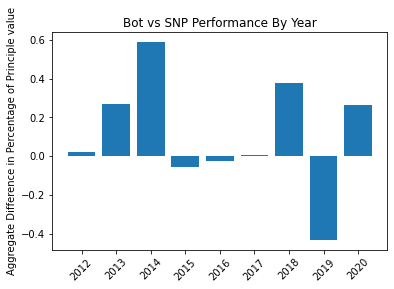

In [10]:
fig, ax = plt.subplots()
ax.bar(together.index.values, together['DIFF'])
ax.set_xticks(np.arange(len(together) ))
ax.set_xticklabels(together.index.values, rotation=45)
ax.set_title('Bot vs SNP Performance By Year')
ax.set_ylabel('Aggregate Difference in Percentage of Principle value')
fig.set_size_inches(6, 4)

In [11]:
snp_perf = get_performance_breakdown(snp, formatters=['%Y', '%m'], date_col='Date', val_col='Close').rename(columns={'Close': 'SNP'})
bot_perf = get_performance_breakdown(value, formatters=['%Y', '%m']).rename(columns={'Close': 'SNP'})
joined = snp_perf.join(bot_perf)
diff = joined['value'] - joined['SNP']
diff = diff.unstack()
diff.columns = [datetime.datetime.strptime(x, '%m').strftime('%B') for x in diff.columns]
diff.style.apply(get_colors, scaler =1/6, axis=0)

,January,February,March,April,May,June,July,August,September,October,November,December
Date0,,,,,,,,,,,,
2012,nan,nan,nan,nan,nan,nan,nan,nan,-0.025432,nan,nan,-0.011870
2013,nan,nan,-0.033586,nan,nan,0.020812,nan,nan,-0.025479,nan,nan,-0.026353
2014,nan,nan,-0.014417,nan,nan,-0.018317,nan,nan,0.014978,nan,nan,-0.002659
2015,nan,nan,0.023378,nan,nan,0.023024,nan,nan,-0.003229,nan,nan,0.027913
2016,nan,nan,-0.041140,nan,nan,0.000224,nan,nan,0.001193,nan,nan,-0.021793
2017,nan,nan,0.013873,nan,nan,0.002737,nan,nan,-0.017286,nan,nan,-0.011880
2018,nan,nan,0.013743,nan,nan,0.005942,nan,nan,-0.005958,nan,nan,0.101607
2019,nan,nan,-0.010953,nan,nan,-0.071894,nan,nan,-0.024248,nan,nan,-0.037545
2020,nan,nan,0.163625,nan,nan,0.000815,nan,nan,nan,nan,nan,nan


In [12]:
## Get the Differences By Month
diff_sum = diff.sum(axis=0)
diff_sum.name = 'Aggregate Difference Between Bot and SNP Performance'
diff_sum.to_frame().style.apply(get_colors)

,Aggregate Difference Between Bot and SNP Performance
January,0.000000
February,0.000000
March,0.114523
April,0.000000
May,0.000000
June,-0.036658
July,0.000000
August,0.000000
September,-0.085461
October,0.000000


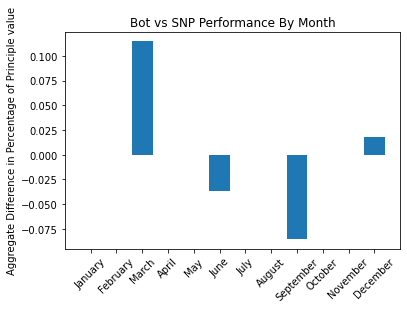

In [13]:
fig, ax = plt.subplots()
ax.bar(diff_sum.index.values, diff_sum)
ax.set_xticks(np.arange(len(diff_sum) ))
ax.set_xticklabels(diff_sum.index.values, rotation=45)
ax.set_title('Bot vs SNP Performance By Month')
ax.set_ylabel('Aggregate Difference in Percentage of Principle value')
fig.set_size_inches(6, 4)

In [14]:
## Dropping duplicates keeps the first value so you can use it to find the first date of each year
years = pd.to_datetime(comb['Date'])
years = years.dt.strftime('%Y').drop_duplicates().to_frame()
years.index.name = 'Index'
years = years.reset_index()

In [24]:
for i, row in comb.iterrows():
    print(row['Date'])

2012-06-30
2012-09-30
2012-12-31
2013-03-31
2013-06-30
2013-06-30
2013-06-30
2013-06-30
2013-06-30
2013-06-30
2013-06-30
2013-06-30
2013-09-30
2013-12-31
2014-03-31
2014-06-30
2014-06-30
2014-06-30
2014-06-30
2014-06-30
2014-06-30
2014-06-30
2014-06-30
2014-09-30
2014-12-31
2015-03-31
2015-06-30
2015-06-30
2015-06-30
2015-06-30
2015-06-30
2015-06-30
2015-06-30
2015-06-30
2015-09-30
2015-12-31
2016-03-31
2016-06-30
2016-06-30
2016-06-30
2016-06-30
2016-06-30
2016-06-30
2016-06-30
2016-06-30
2016-09-30
2016-12-31
2017-03-31
2017-06-30
2017-06-30
2017-06-30
2017-06-30
2017-06-30
2017-06-30
2017-06-30
2017-06-30
2017-09-30
2017-12-31
2018-03-31
2018-06-30
2018-06-30
2018-06-30
2018-06-30
2018-06-30
2018-06-30
2018-06-30
2018-06-30
2018-09-30
2018-12-31
2019-03-31
2019-06-30
2019-06-30
2019-06-30
2019-06-30
2019-06-30
2019-06-30
2019-06-30
2019-06-30
2019-09-30
2019-12-31
2020-03-31
2020-06-30


In [15]:
# Find the points where the value of the portfolio didn't change
starts = []
ends = []
cur_row = 0
cur_val = None
val_start = None
monitoring = False
for i, row in comb.iterrows():
    if cur_val is None:
        cur_val = row['value']
        val_start = cur_row
    elif row['value'] == cur_val and not monitoring:
        starts.append(val_start)
        monitoring=True
    else:
        cur_val = row['value']
        val_start = cur_row
        if monitoring:
            ends.append(cur_row)
            monitoring = False
    cur_row += 1
if len(ends) == len(starts) - 1:
    ends.append(len(comb) - 1)

In [16]:
len(starts), len(ends)

(28, 28)

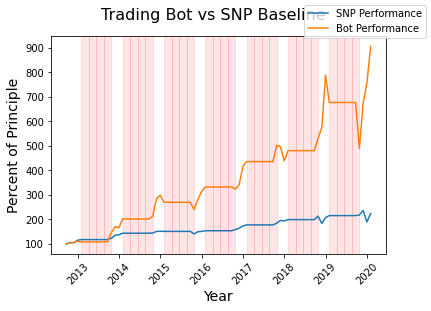

In [17]:
fig, ax = plt.subplots()
x = np.arange(len(comb))
ax.plot(x, comb['Close'], label='SNP Performance')
ax.plot(x, comb['value'], label='Bot Performance')
ax.set_xticks(years['Index'].values[1:])
ax.set_xticklabels(years['Date'].values[1:], rotation=45)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Percent of Principle', fontsize=14)

## Add the no trading regions
for i in range(len(starts)):
    ax.axvspan(starts[i], ends[i], color='red', alpha=0.1)
fig.set_size_inches(6, 4)
fig.suptitle('Trading Bot vs SNP Baseline', fontsize=16)
fig.legend()
plt.savefig(meta.results_loc + str(datetime.datetime.now()) + '.png')

## Plot the rate of change of the graph above to see if the bot is just exagerating market movement

In [212]:
window = 2
step = 1

## We start the window at the start of the series and just move it down by step
## The only complication is the date associated with the value at each window
## We can say the date used should be the midpoint of the window.

## How do we align with the graph above?
    # In addition to date as the midpoint, there will be a new column where we track the
    # Index of the date we take

ret = []
date_col = comb.columns.get_loc('Date')
close_col = comb.columns.get_loc('Close')
val_col = comb.columns.get_loc('value')
for i in range(0, len(comb) - window + 1, step):
    mid = i + window // 2
    close_slope = (comb.iloc[i+window - 1, close_col] - comb.iloc[i, close_col]) / window
    val_slope = (comb.iloc[i+window - 1, val_col] - comb.iloc[i, val_col]) / window
    ret.append((comb.iloc[mid, date_col], mid, close_slope, val_slope))
    
slope = pd.DataFrame(ret, columns=['Date', 'Index', 'Close', 'Value'])
slope['Date'] = pd.to_datetime(slope['Date']).dt.strftime('%Y').astype(int)


In [213]:
## Because the association looks pretty linear, We can fit a linear model
## To estimate the rate of change of the trading bot by the rate of change of the snp 500
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(slope['Close'].values[:, np.newaxis], slope['Value'].values)
predictions = model.predict(slope['Close'].values[:, np.newaxis])
model.intercept_, model.coef_

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

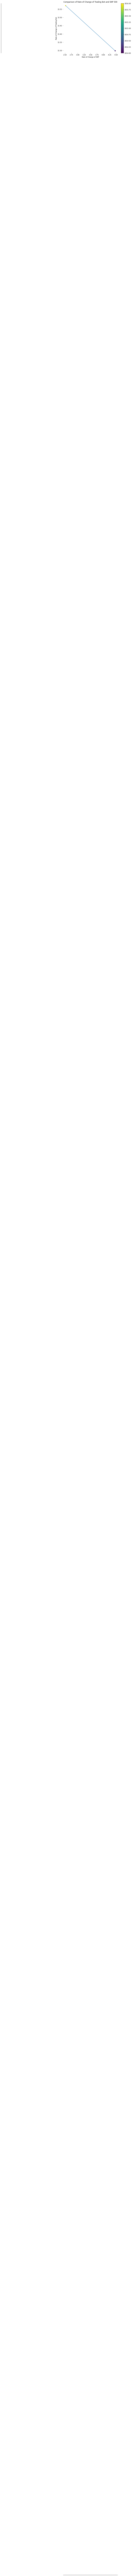

In [146]:
fig, ax = plt.subplots()
cbar = ax.scatter(slope['Close'].values, slope['Value'].values, c=slope['Date'].values)
ax.set_xlabel('Rate of Change of SNP')
ax.set_ylabel('Rate of Change of Trading Bot')

# Move the axes
ax.spines['right'].set_position('zero')
ax.spines['top'].set_position('zero')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.plot(slope['Close'].values, predictions)
ax.set_title('Comparison of Rate of Change of Trading Bot and SNP 500')
fig.set_size_inches(8, 6)
fig.colorbar(cbar, ax=ax)

## Model Performance Analysis
- I have noticed some deterioration in model performance which is what lead me to want to retrain
- This graph shows the mean sqared error over a window for the model

In [ ]:
window = 60
step = 1
trades = pd.read_csv(meta.trades_loc)
trades['sell_date'] = pd.to_datetime(trades['sell_date'])
pred_col = trades.columns.get_loc('predicted_change')
act_col = trades.columns.get_loc('actual_change')

perf_tups = []
for i in range(0, len(trades) - window + 1, step):
    mid_dex = i + window // 2
    sell_date = trades.iloc[mid_dex, trades.columns.get_loc('sell_date')]
    pred = trades.iloc[i:i+window, pred_col]
    act = trades.iloc[i:i+window, act_col]
    mse = ((pred - act) ** 2).mean()
    hl = (((pred > 1) & (act > 1)) | ((pred < 1) & (act < 1))).mean()
    perf_tups.append((mid_dex, sell_date, mse, hl))
    
perf_df = pd.DataFrame(perf_tups, columns=['index', 'sell_date', 'mse', 'hl'])

In [ ]:
np.arange(1, 21, 11)


array([ 1, 12])

[Text(0, 0, '2012'),
 Text(150, 0, '2013'),
 Text(934, 0, '2014'),
 Text(2266, 0, '2015'),
 Text(3447, 0, '2016'),
 Text(4475, 0, '2017'),
 Text(5896, 0, '2018'),
 Text(7349, 0, '2019'),
 Text(8825, 0, '2020')]

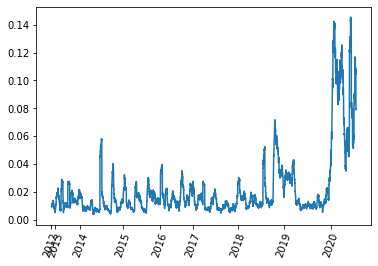

In [ ]:
fig, ax = plt.subplots()
ax.plot(perf_df['index'], perf_df['mse'], label='Mean Squared Error')
dates = perf_df['sell_date'].dt.strftime('%Y').drop_duplicates()
ax.set_xticks(dates.index)
ax.set_xticklabels(dates, rotation=70)


## Trade Analysis

In [ ]:
trades_df = pd.read_csv('../data_files/backtest_data/trade.csv')
trades_df

,ticker,buy_date,sell_date,num_shares,buy_price,sell_price,week_rank,position,predicted_change,actual_change
0,PNW,2012-06-30,2012-09-30,271.0,36.824894,37.946075,0,buy,1.073138,1.030446
1,IRM,2012-06-30,2012-09-30,657.0,15.208738,15.866121,1,buy,1.064176,1.043224
2,LNT,2012-06-30,2012-09-30,599.0,16.689945,16.045212,2,buy,1.050734,0.961370
3,NRG,2012-06-30,2012-09-30,686.0,14.566674,18.030256,3,buy,1.050016,1.237774
4,EW,2012-06-30,2012-09-30,580.0,17.216667,17.895000,4,buy,1.048701,1.039400
...,...,...,...,...,...,...,...,...,...,...
9652,DIS,2020-03-31,2020-06-30,0.0,96.599998,111.510002,393,buy,1.008183,1.154348
9653,TPR,2020-03-31,2020-06-30,0.0,12.870297,13.198267,394,buy,1.007029,1.025483
9654,MDLZ,2020-03-31,2020-06-30,0.0,48.460270,49.759483,395,buy,1.006789,1.026810
9655,HES,2020-03-31,2020-06-30,0.0,32.471806,50.782837,396,buy,1.005717,1.563906


In [ ]:
(trades_df['num_shares'] * trades_df['buy_price'] * trades_df['actual_change']).sum() - (trades_df['num_shares'] * trades_df['buy_price']).sum()

852718.8232795

In [ ]:
(trades_df['actual_change'] > 1).mean()

0.6324945635290463

          COUNT
position       
buy       100.0


ValueError: x must be 1D

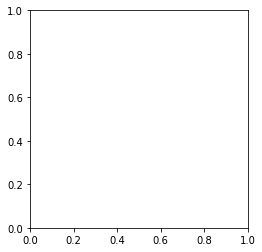

In [ ]:
fig, ax = plt.subplots()
total_rows = len(trades_df)
buy_sell = trades_df.groupby('position').agg(COUNT=('position', 'count'))
buy_sell = buy_sell / total_rows * 100
print(buy_sell)
ax.pie(buy_sell.values, labels=buy_sell.index.values)